
# GROUPE 14 — Détection automatique des œufs sains et défectueux
## Good and Bad Eggs Identification Image Dataset




### Importation des librairies

In [2]:
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import cv2
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

import torch
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image

try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except:
    XGBOOST_AVAILABLE = False

try:
    import umap
    UMAP_AVAILABLE = True
except:
    UMAP_AVAILABLE = False

warnings.filterwarnings('ignore')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
RANDOM_STATE = 42



## 1. Chargement des données


In [3]:
DATA_ROOT = Path(r'C:\Users\cheic\Documents\M2 IA MathInfo\DeepL\PROJET FINAL DPL')
original_dir = DATA_ROOT / 'Original Images(Eggs)'
aug_dir = DATA_ROOT / 'Augmented_Images(Eggs)'

def gather_paths(base_dir):
    rows = []
    if not base_dir.exists():
        return rows
    for label_dir in ['Good Eggs', 'Bad Eggs']:
        class_path = base_dir / label_dir
        if not class_path.exists():
            continue
        for img_path in class_path.glob('*'):
            if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                rows.append({
                    'path': str(img_path),
                    'label': 'good' if 'Good' in label_dir else 'bad',
                    'source': base_dir.name
                })
    return rows

# Chargement séparé
df_orig = pd.DataFrame(gather_paths(original_dir))
df_aug = pd.DataFrame(gather_paths(aug_dir))

# Encodage
df_orig['label_enc'] = df_orig['label'].map({'good': 0, 'bad': 1})
df_aug['label_enc'] = df_aug['label'].map({'good': 0, 'bad': 1})

# Split rigoureux train/val/test sur originales uniquement
train_orig, temp = train_test_split(df_orig, test_size=0.3, stratify=df_orig['label_enc'], random_state=RANDOM_STATE)
val_orig, test_orig = train_test_split(temp, test_size=0.5, stratify=temp['label_enc'], random_state=RANDOM_STATE)

# Ajout des augmentations au train uniquement
df_train = pd.concat([train_orig, df_aug], ignore_index=True)
df_val = val_orig.copy()
df_test = test_orig.copy()

print(f"Train: {len(df_train)}, Validation: {len(df_val)}, Test: {len(df_test)}")


Train: 6700, Validation: 150, Test: 150



## 2. Prétraitements


In [4]:
def preprocess_image(img_path, target_size=(224,224), apply_clahe=True):
    """Prétraitement uniforme pour toutes les images (classiques et deep)"""
    img = cv2.imread(img_path)
    if img is None:
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    gray = cv2.medianBlur(gray, 5)
    if apply_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        gray = clahe.apply(gray)
    gray_resized = cv2.resize(gray, target_size, interpolation=cv2.INTER_AREA)
    return gray_resized.astype(np.float32) / 255.0

def preprocess_image_rgb(img_path, target_size=(224,224)):
    """Prétraitement pour les modèles profonds (RGB)"""
    img_gray = preprocess_image(img_path, target_size=target_size, apply_clahe=True)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32)/255.0
    return img, img_gray  # retourne RGB et grayscale

print("Prétraitement configuré: normalisation, filtre médian, CLAHE, redimensionnement")

Prétraitement configuré: normalisation, filtre médian, CLAHE, redimensionnement



## 3. Extracteurs classiques


HOG – fissures et contours

In [5]:
def extract_hog(img_gray):
    img_uint8 = (img_gray*255).astype(np.uint8)
    return hog(img_uint8, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), feature_vector=True)

LBP multi-échelle – texture

In [6]:
def extract_lbp(img_gray):
    img_uint8 = (img_gray*255).astype(np.uint8)
    lbp_features = []
    for radius, n_points in zip([1,2,3],[8,16,24]):
        lbp = local_binary_pattern(img_uint8, n_points, radius, method='uniform')
        hist,_ = np.histogram(lbp.ravel(), bins=np.arange(0,n_points+3), range=(0,n_points+2), density=True)
        lbp_features.extend(hist)
    return np.array(lbp_features)

GLCM

In [7]:
def extract_glcm(img_gray):
    img_uint8 = (img_gray*255).astype(np.uint8)
    glcm = graycomatrix(img_uint8, distances=[1,2], angles=[0,np.pi/4,np.pi/2], levels=256, symmetric=True, normed=True)
    features = []
    for prop in ['contrast','homogeneity','energy','correlation']:
        features.extend(graycoprops(glcm, prop).ravel())
    return np.array(features)

Moments de Hu – formes irrégulières

In [8]:
def extract_hu_moments(img_gray):
    img_uint8 = (img_gray*255).astype(np.uint8)
    moments = cv2.moments(img_uint8)
    hu = cv2.HuMoments(moments)
    hu = -np.sign(hu) * np.log10(np.abs(hu)+1e-10)
    return hu.flatten()

Histogrammes HSV – décoloration

In [9]:
def extract_hsv_histogram(img_path):
    img = cv2.imread(img_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv],[0,1,2],None,[16,16,16],[0,180,0,256,0,256])
    cv2.normalize(hist,hist)
    return hist.flatten()

Extraction globale des caractéristiques

In [10]:
def extract_classical_features(img_path):
    _, img_gray = preprocess_image_rgb(img_path)
    return np.concatenate([
        extract_hog(img_gray),
        extract_lbp(img_gray),
        extract_glcm(img_gray),
        extract_hu_moments(img_gray),
        extract_hsv_histogram(img_path)
    ])

print("Extracteurs classiques: HOG, LBP, GLCM, Hu, HSV")

Extracteurs classiques: HOG, LBP, GLCM, Hu, HSV



## 4. Extracteurs profonds


In [11]:
#Transformations ImageNet
transform_imagenet = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

#chargement image RGB
def load_image_tensor(path):
    img = Image.open(path).convert('RGB')
    return transform_imagenet(img).unsqueeze(0)



EfficientNet-B0 / B2, ConvNeXt-Tiny, Swin Transformer (vision globale), RegNetY

In [12]:
def get_deep_model(name):
    """Instanciation unique du modèle profond"""
    if name=='efficientnet_b0':
        model = models.efficientnet_b0(weights='IMAGENET1K_V1')
        model.classifier = torch.nn.Identity()
    elif name=='efficientnet_b2':
        model = models.efficientnet_b2(weights='IMAGENET1K_V1')
        model.classifier = torch.nn.Identity()
    elif name=='convnext':
        model = models.convnext_tiny(weights='IMAGENET1K_V1')
        model.classifier = torch.nn.Identity()
    elif name=='swin':
        model = models.swin_t(weights='IMAGENET1K_V1')
        model.head = torch.nn.Identity()
    elif name=='regnet':
        model = models.regnet_y_400mf(weights='IMAGENET1K_V1')
        model.fc = torch.nn.Identity()
    else:
        raise ValueError(f"Modèle inconnu: {name}")
    model.eval().to(device)
    return model

Extraction

In [13]:
def extract_deep_features_batch(df, model_name='efficientnet_b0'):
    """Extraction optimisée pour toutes les images du DataFrame"""
    model = get_deep_model(model_name)
    features, labels = [], []
    for _, row in tqdm(df.iterrows(), total=len(df), leave=False):
        try:
            img_tensor = load_image_tensor(row['path']).to(device)
            with torch.no_grad():
                feat = model(img_tensor)
            features.append(feat.cpu().squeeze().numpy())
            labels.append(row['label_enc'])
        except:
            continue
    return np.array(features), np.array(labels)



## 5. Extracteurs hybrides


CNN + GLCM (vision globale + texture)

In [14]:
def extract_hybrid_cnn_glcm(df):
    model = get_deep_model('efficientnet_b0')
    X, y = [], []
    for _, row in tqdm(df.iterrows(), total=len(df), leave=False):
        try:
            img_tensor = load_image_tensor(row['path']).to(device)
            with torch.no_grad():
                cnn_feat = model(img_tensor).cpu().squeeze().numpy()
            _, img_gray = preprocess_image_rgb(row['path'])
            glcm_feat = extract_glcm(img_gray)
            X.append(np.concatenate([cnn_feat,glcm_feat]))
            y.append(row['label_enc'])
        except:
            continue
    return np.array(X), np.array(y)

Transformer + HOG (attention + contours)

In [15]:
def extract_hybrid_swin_hog(df):
    model = get_deep_model('swin')
    X, y = [], []
    for _, row in tqdm(df.iterrows(), total=len(df), leave=False):
        try:
            img_tensor = load_image_tensor(row['path']).to(device)
            with torch.no_grad():
                swin_feat = model(img_tensor).cpu().squeeze().numpy()
            _, img_gray = preprocess_image_rgb(row['path'])
            hog_feat = extract_hog(img_gray)
            X.append(np.concatenate([swin_feat,hog_feat]))
            y.append(row['label_enc'])
        except:
            continue
    return np.array(X), np.array(y)

Autoencoder convolutionnel

Masked Autoencoder (MAE)


## 7. Réduction de dimension


Approches statistiques

PCA

In [16]:
def reduce_pca(X_train, X_val, X_test, n_components=128):
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    return pca.fit_transform(X_train), pca.transform(X_val), pca.transform(X_test)

ICA

In [17]:
def reduce_ica(X_train, X_val, X_test, n_components=128):
    ica = FastICA(n_components=n_components, random_state=RANDOM_STATE, max_iter=500)
    return ica.fit_transform(X_train), ica.transform(X_val), ica.transform(X_test)

TUNCATED SVD

In [18]:
def reduce_svd(X_train, X_val, X_test, n_components=128):
    svd = TruncatedSVD(n_components=n_components, random_state=RANDOM_STATE)
    return svd.fit_transform(X_train), svd.transform(X_val), svd.transform(X_test)

Approches deep learning

Parametric UMAP

In [19]:
def reduce_umap(X_train, X_val, X_test, n_components=128):
    if not UMAP_AVAILABLE:
        return X_train, X_val, X_test
    reducer = umap.UMAP(n_components=n_components, random_state=RANDOM_STATE)
    return reducer.fit_transform(X_train), reducer.transform(X_val), reducer.transform(X_test)

Deep Embedding Reduction Network


## 8. CLASSIFICATEURS


In [20]:
def get_classifier(name):
    classifiers = {
        'svm': SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_STATE),
        'rf': RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
        'xgb': XGBClassifier(n_estimators=200, random_state=RANDOM_STATE) if XGBOOST_AVAILABLE else None,
        'mlp': MLPClassifier(hidden_layer_sizes=(256,128), max_iter=300, random_state=RANDOM_STATE),
        'knn': KNeighborsClassifier(n_neighbors=7, weights='distance'),
        'logreg': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE)
    }
    return classifiers[name]


# Partie 7 : PIPELINE

In [21]:
def run_experiment(df_train, df_val, df_test, feature_type, reduction=None, n_components=128, classifier_name='svm'):
    print(f"\n{'='*60}\nExpérience: {feature_type} + {reduction or 'none'} + {classifier_name}\n{'='*60}")
    
    # Extraction features
    if feature_type=='classical':
        X_train = np.array([extract_classical_features(p) for p in df_train['path']])
        X_val = np.array([extract_classical_features(p) for p in df_val['path']])
        X_test = np.array([extract_classical_features(p) for p in df_test['path']])
        y_train = df_train['label_enc'].values
        y_val = df_val['label_enc'].values
        y_test = df_test['label_enc'].values
    elif feature_type in ['efficientnet_b0','efficientnet_b2','convnext','swin','regnet']:
        X_train, y_train = extract_deep_features_batch(df_train, feature_type)
        X_val, y_val = extract_deep_features_batch(df_val, feature_type)
        X_test, y_test = extract_deep_features_batch(df_test, feature_type)
    elif feature_type=='hybrid_cnn_glcm':
        X_train, y_train = extract_hybrid_cnn_glcm(df_train)
        X_val, y_val = extract_hybrid_cnn_glcm(df_val)
        X_test, y_test = extract_hybrid_cnn_glcm(df_test)
    elif feature_type=='hybrid_swin_hog':
        X_train, y_train = extract_hybrid_swin_hog(df_train)
        X_val, y_val = extract_hybrid_swin_hog(df_val)
        X_test, y_test = extract_hybrid_swin_hog(df_test)
    else:
        raise ValueError(f"Feature type inconnu: {feature_type}")

    # Normalisation
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Réduction dimensionnelle
    if reduction=='pca':
        X_train, X_val, X_test = reduce_pca(X_train, X_val, X_test, n_components)
    elif reduction=='ica':
        X_train, X_val, X_test = reduce_ica(X_train, X_val, X_test, n_components)
    elif reduction=='svd':
        X_train, X_val, X_test = reduce_svd(X_train, X_val, X_test, n_components)
    elif reduction=='umap':
        X_train, X_val, X_test = reduce_umap(X_train, X_val, X_test, n_components)

    # Classificateur
    clf = get_classifier(classifier_name)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Métriques
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    recall_good = recall_score(y_test, y_pred, pos_label=0)
    recall_bad = recall_score(y_test, y_pred, pos_label=1)
    cm = confusion_matrix(y_test, y_pred)

    return {
        'feature_type': feature_type,
        'reduction': reduction or 'none',
        'classifier': classifier_name,
        'accuracy': acc,
        'f1_score': f1,
        'recall_good': recall_good,
        'recall_bad': recall_bad,
        'confusion_matrix': cm
    }


### TEST ET COMPARAISON


Expérience: classical + none + svm

Expérience: classical + none + rf

Expérience: classical + pca + svm

Expérience: classical + pca + rf

Expérience: classical + ica + svm

Expérience: classical + ica + rf

Expérience: classical + svd + svm

Expérience: classical + svd + rf

Expérience: efficientnet_b0 + none + svm



Expérience: efficientnet_b0 + none + rf



Expérience: efficientnet_b0 + pca + svm



Expérience: efficientnet_b0 + pca + rf



Expérience: efficientnet_b0 + ica + svm



Expérience: efficientnet_b0 + ica + rf



Expérience: efficientnet_b0 + svd + svm



Expérience: efficientnet_b0 + svd + rf



Expérience: swin + none + svm



Expérience: swin + none + rf



Expérience: swin + pca + svm



Expérience: swin + pca + rf



Expérience: swin + ica + svm



Expérience: swin + ica + rf



Expérience: swin + svd + svm



Expérience: swin + svd + rf



Expérience: hybrid_cnn_glcm + none + svm



Expérience: hybrid_cnn_glcm + none + rf



Expérience: hybrid_cnn_glcm + pca + svm



Expérience: hybrid_cnn_glcm + pca + rf



Expérience: hybrid_cnn_glcm + ica + svm



Expérience: hybrid_cnn_glcm + ica + rf



Expérience: hybrid_cnn_glcm + svd + svm



Expérience: hybrid_cnn_glcm + svd + rf



Expérience: hybrid_swin_hog + none + svm



Expérience: hybrid_swin_hog + none + rf



Expérience: hybrid_swin_hog + pca + svm



Expérience: hybrid_swin_hog + pca + rf



Expérience: hybrid_swin_hog + ica + svm



Expérience: hybrid_swin_hog + ica + rf



Expérience: hybrid_swin_hog + svd + svm



Expérience: hybrid_swin_hog + svd + rf



Expérience: classical + pca + xgb


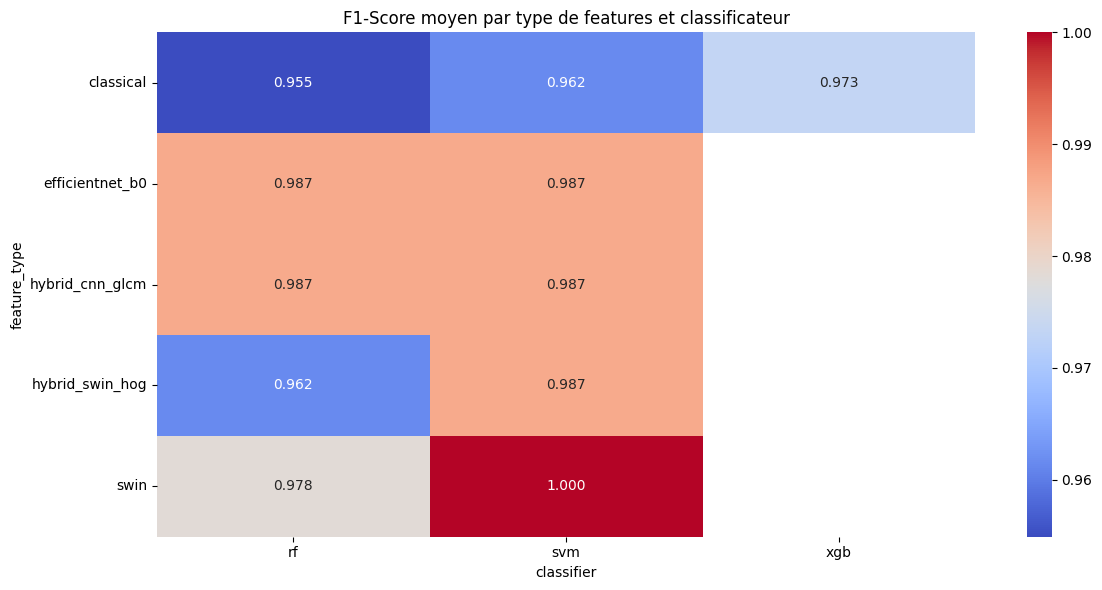

In [ ]:
results = []
feature_list = ['classical','efficientnet_b0','swin','hybrid_cnn_glcm','hybrid_swin_hog']
reduction_list = [None,'pca','ica','svd']

for feature in feature_list:
    for red in reduction_list:
        for clf_name in ['svm','rf']:
            if red is None or feature=='classical' or clf_name in ['svm','rf']:
                results.append(run_experiment(df_train, df_val, df_test, feature, red, n_components=128, classifier_name=clf_name))
if XGBOOST_AVAILABLE:
    results.append(run_experiment(df_train, df_val, df_test, 'classical', 'pca', classifier_name='xgb'))

# Tableau comparatif
df_results = pd.DataFrame([{k:v for k,v in r.items() if k!='confusion_matrix'} for r in results])
df_results = df_results.sort_values('f1_score', ascending=False).reset_index(drop=True)

# Heatmap F1-score
plt.figure(figsize=(12,6))
pivot = df_results.pivot_table(values='f1_score', index='feature_type', columns='classifier', aggfunc='mean')
sns.heatmap(pivot, annot=True, cmap='coolwarm', fmt=".3f")
plt.title("F1-Score moyen par type de features et classificateur")
plt.tight_layout()
plt.show()



### MATRICE DE CONFUSION DU MEILLEUR CHOIX
Hybrid CNN + GLCM + SVM

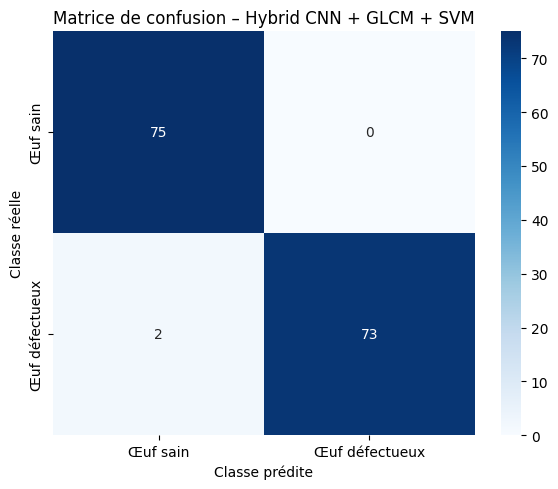

In [31]:
best_result = next(
    r for r in results
    if r['feature_type'] == 'hybrid_cnn_glcm' and r['classifier'] == 'svm'
)

cm = best_result['confusion_matrix']

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Œuf sain', 'Œuf défectueux'],
    yticklabels=['Œuf sain', 'Œuf défectueux']
)

plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Hybrid CNN + GLCM + SVM")
plt.tight_layout()
plt.show()


### ENTRAÎNEMENT FINAL DU MEILLEUR MODELE

In [32]:
X_final, y_final = extract_hybrid_cnn_glcm(df_train)


### SCALER FINAL

In [33]:
scaler_final = StandardScaler()
X_final = scaler_final.fit_transform(X_final)

### REDUCTION FINALE

In [34]:
pca_final = PCA(n_components=128, random_state=RANDOM_STATE)
X_final = pca_final.fit_transform(X_final)


### MODELE FINAL

In [35]:
clf_final = SVC(
    kernel='rbf',
    probability=True,
    class_weight='balanced',
    random_state=RANDOM_STATE
)

# Entraînement
clf_final.fit(X_final, y_final)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


### CREATION DU PIPELINE

In [36]:
import joblib
from sklearn.pipeline import Pipeline

pipeline_qualite_oeuf = Pipeline(steps=[
    ("scaler", scaler_final),
    ("reduction", pca_final),
    ("classifier", clf_final)
])

joblib.dump(pipeline_qualite_oeuf, "pipeline_qualite_oeuf.joblib")

print("Pipeline final créé et sauvegardé avec succès.")



Pipeline final créé et sauvegardé avec succès.


### TEST DU PIPELINE

In [38]:
# Chargement du pipeline
pipeline_test = joblib.load("pipeline_qualite_oeuf.joblib")

# Extraction DES FEATURES HYBRIDES (obligatoire avant le pipeline)
X_test_final, y_test_final = extract_hybrid_cnn_glcm(df_test)

# Prédiction
y_pred = pipeline_test.predict(X_test_final)

print("Prédictions OK :", y_pred[:10])


Prédictions OK : [0 1 1 1 1 1 1 1 0 1]


In [41]:
joblib.dump(pipeline_qualite_oeuf, "pipeline_qualite_oeuf.plk")

['pipeline_qualite_oeuf.plk']


## 10. Discussion et limites

Les erreurs de classification concernent principalement :
- des fissures très fines,
- des variations d’éclairage importantes,
- des coquilles naturellement atypiques.

Des améliorations possibles incluent l’augmentation de données,
une acquisition contrôlée et l’intégration temps réel en chaîne industrielle.
